## Objective: To build a model that predicts whether the given chest_x_ray image belongs to pneuominia or not.

## Business Metrics:
- At any cost our model should not classify a pnuomina pateint x_ray as normal,
- So we should target very high recall rate, Also we should not loose the precision too.
- So there will always be tradeoff between both, We can consider F1-score as a good metric for this problem, with special emphasize on recall rate.

In [2]:
# lets initially import the necessary libraries
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from skimage import io
from numpy.random import seed
seed(64)
from tensorflow import set_random_seed
set_random_seed(64)
import sys
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [3]:
print(os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"))

['train', 'val', '.DS_Store', 'test']


In [4]:
# lets set the directory path so that we can use later.
dir_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
# lets see one of the pneumonia image from train data
os.listdir(dir_path+'/train/PNEUMONIA')[:4]

['person498_bacteria_2102.jpeg',
 'person374_bacteria_1712.jpeg',
 'person1876_bacteria_4760.jpeg',
 'person1233_bacteria_3188.jpeg']

In [5]:
os.listdir(dir_path+'/train/NORMAL')[:4]

['NORMAL2-IM-1051-0001.jpeg',
 'NORMAL2-IM-1269-0001.jpeg',
 'NORMAL2-IM-0974-0001.jpeg',
 'IM-0361-0001.jpeg']

In [6]:
sample_pn_img = io.imread(dir_path+'/train/PNEUMONIA/person498_bacteria_2102.jpeg')
sample_nor_img = io.imread(dir_path+'/train/NORMAL/NORMAL2-IM-1051-0001.jpeg')

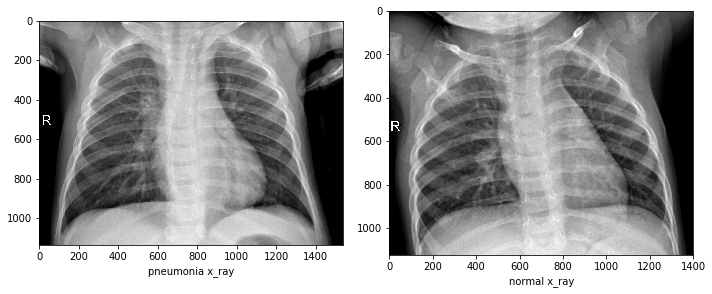

In [7]:
# lets see a pneumonia and normal x_ray
fig, ax = plt.subplots(1, 2)#, sharey=True)
fig.set_figwidth(10)
fig.set_figheight(8)
ax[0].imshow(sample_pn_img, cmap='gray');
ax[0].set_xlabel("pneumonia x_ray")
ax[1].imshow(sample_nor_img, cmap='gray');
ax[1].set_xlabel('normal x_ray')
plt.tight_layout()
plt.show()

## DATA PREPARATION:
## Lets progressively load the train, validation and test data using the ImageDataGenerator of keras.

In [8]:
# Lets initiate the imagedatagenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [15]:
ImageDataGenerator?

In [9]:
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size, class_mode='binary')
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


- From above we can see:
- There are total 5216 images in training data.
- There are total 16 images in validation data which is low.
- There are total 624 images in the testing data.

In [10]:
train_len = 5216
val_len = 16
test_len = 624

In [11]:
train_generator.reset()
batchX, batchY = train_generator.next()
print(batchX.shape)
print(batchY.shape)
print(np.unique(batchY))
train_generator.class_indices

(16, 256, 256, 3)
(16,)
[0. 1.]


{'NORMAL': 0, 'PNEUMONIA': 1}

- As we can see from above:
- the first batch of training data contains total 16 images with 256 by 256 size
- Also the batchY have only 0 and 1 values in which:
    - 0 represents Normal
    - 1 represents PNEUMONIA according to there alphebatical orders(keras conventions)

# Base Model:

- Lets create a baseline model first and then improve our architecture based on the results of baseline model.
- As CNN works best on image data, we will build a very basic CNN model and will improve upon that.
- Lets also try a pretrained network all vgg16 and see whether we require the pretrained model for this problem.

In [12]:
# lets first import all the necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping

In [13]:
# lets build very basic model
def def_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
# lets compile our model
model = def_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               51612900  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 51,613,897
Trainable params: 51,613,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
# lets train our model now:
early_stopping_monitor = EarlyStopping(patience=2) 
history = model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor])
model.save_weights('first_try.h5')

Epoch 1/100
326/326 [==============================] - 143s 440ms/step - loss: 4.1107 - acc: 0.7396 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/100
326/326 [==============================] - 134s 411ms/step - loss: 4.0865 - acc: 0.7437 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/100
326/326 [==============================] - 135s 414ms/step - loss: 4.1048 - acc: 0.7425 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/100
326/326 [==============================] - 134s 412ms/step - loss: 4.1079 - acc: 0.7423 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/100
326/326 [==============================] - 135s 415ms/step - loss: 4.0773 - acc: 0.7442 - val_loss: 7.9712 - val_acc: 0.5000


In [47]:
def model_plots(history):
    # plot loss
    fig, ax = plt.subplots(1, 2);
    fig.set_figwidth(12);
    fig.set_figheight(6);
    
    ax[0].plot(history.history['loss'], color='blue', label='train');
    ax[0].plot(history.history['val_loss'], color='orange', label='val');
    ax[0].set_xlabel('epochs');
    ax[0].set_title("cross entropy loss");
    ax[0].legend();
    # plot accuracy
    
    ax[1].plot(history.history['acc'], color='blue', label='train');
    ax[1].plot(history.history['val_acc'], color='orange', label='val');
    ax[1].set_xlabel('epochs');
    ax[1].set_title('Classification Accuracy');
    ax[1].legend();
    plt.tight_layout();
    plt.show();
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png');

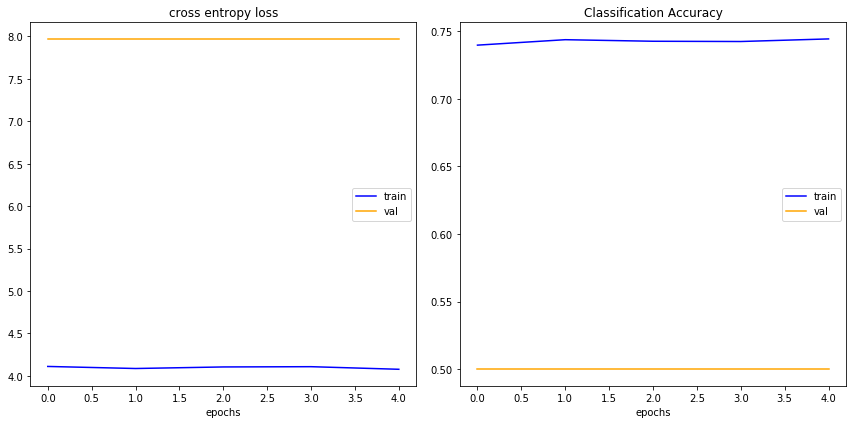

<Figure size 432x288 with 0 Axes>

In [48]:
model_plots(history)

- As we can see with this simple model we are getting validation accuracy of 0.5 and train accuracy of 0.744
- Lets try to improve our model further and lets see whether it improves or not.

- From above we can see our model is not improving over epochs and also we have a classimbalance here
- Lets take care of class imbalance first before trying to improve our model.

In [49]:
from sklearn.utils import class_weight
train_labels = train_generator.labels
unique_labels = np.unique(train_labels)

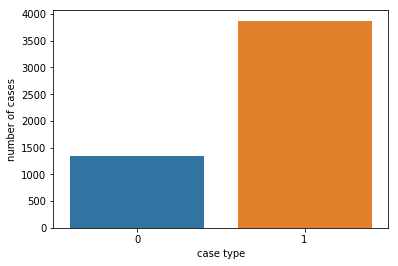

In [52]:
sns.countplot(train_labels);
plt.xlabel('case type');
plt.ylabel('number of cases');

- As we can number of pneumonia x_rays are more than normal x_rays.
- Lets solve the class imbalance problem by associating respective class weights.

In [53]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 unique_labels,
                                                 train_labels)
class_weight_dict = dict(enumerate(class_weights))

In [54]:
class_weight_dict

{0: 1.9448173005219984, 1: 0.6730322580645162}

- Now we have class_weights which we can use while trianing our models.
- Lets improve our architecture.

In [55]:
from keras.optimizers import adam

In [56]:
#lets change our model and see if it improves
def three_conv_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               51612900  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 51,613,897
Trainable params: 51,613,897
Non-trainable params: 0
_________________________________________________________________


In [58]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(64, 64))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [59]:
mul_conv_model = three_conv_model()
early_stopping_monitor = EarlyStopping(patience=5) 
mul_conv_history = mul_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor],\
                   class_weight=class_weight_dict)

Epoch 1/100
326/326 [==============================] - 70s 215ms/step - loss: 0.4815 - acc: 0.7563 - val_loss: 0.3570 - val_acc: 0.7500
Epoch 2/100
326/326 [==============================] - 69s 212ms/step - loss: 0.2507 - acc: 0.8976 - val_loss: 0.4280 - val_acc: 0.8125
Epoch 3/100
326/326 [==============================] - 69s 213ms/step - loss: 0.2144 - acc: 0.9107 - val_loss: 0.3932 - val_acc: 0.8125
Epoch 4/100
326/326 [==============================] - 69s 212ms/step - loss: 0.2021 - acc: 0.9191 - val_loss: 0.7007 - val_acc: 0.6875
Epoch 5/100
326/326 [==============================] - 70s 214ms/step - loss: 0.1789 - acc: 0.9266 - val_loss: 0.4670 - val_acc: 0.8125
Epoch 6/100
326/326 [==============================] - 70s 214ms/step - loss: 0.1718 - acc: 0.9312 - val_loss: 0.6710 - val_acc: 0.6250


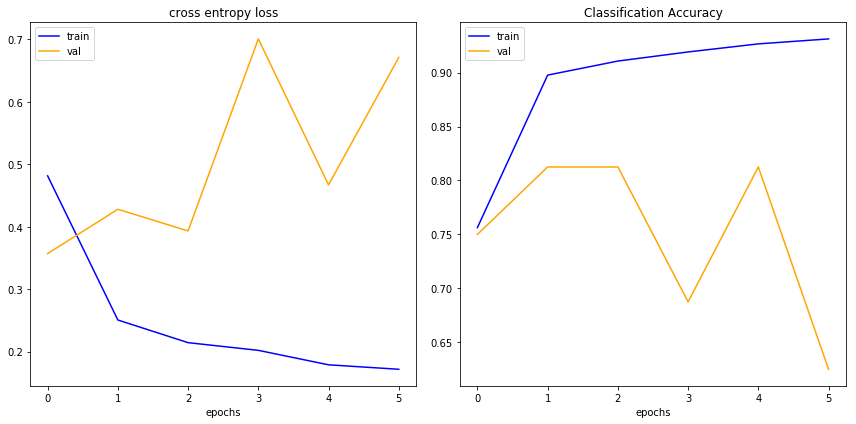

<Figure size 432x288 with 0 Axes>

In [60]:
model_plots(mul_conv_history)

- We can see our model learning and also our validation accuracy varied between 0.62 to 0.81
- Although thats not a great valdation accuracy but definitely better our base line model
- Lets now evalute our model on test data.

In [61]:
test_loss, acc = mul_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using further improved convolution neural networks is {acc * 100.0}%')
print(f'test loss on test data using further improved convolution neural networks is {test_loss}')

accuracy on test data using further improved convolution neural networks is 87.98076923076923%
test loss on test data using further improved convolution neural networks is 0.4224314107798422


- We are getting accuracy of 87.98% which is not bad for start.

## Lets try using pretrained vgg16 model now.

In [63]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD, Nadam
from keras.models import Model

In [64]:
def define_vggmodel():
    # load model
    model = VGG16(include_top=False, input_shape=(64, 64, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [65]:
vgg_model = define_vggmodel()
vgg_early_stopping_monitor = EarlyStopping(patience=5) 
vgg_history = vgg_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [vgg_early_stopping_monitor],\
                   class_weight=class_weight_dict)

58892288/58889256 [==============================] - 3s 0us/step
Epoch 1/100
326/326 [==============================] - 72s 222ms/step - loss: 0.4090 - acc: 0.8198 - val_loss: 0.3391 - val_acc: 0.8125
Epoch 2/100
326/326 [==============================] - 70s 215ms/step - loss: 0.2962 - acc: 0.8737 - val_loss: 0.3258 - val_acc: 0.7500
Epoch 3/100
326/326 [==============================] - 70s 216ms/step - loss: 0.2491 - acc: 0.8986 - val_loss: 0.2876 - val_acc: 0.8750
Epoch 4/100
326/326 [==============================] - 69s 210ms/step - loss: 0.2439 - acc: 0.9045 - val_loss: 0.2547 - val_acc: 0.9375
Epoch 5/100
326/326 [==============================] - 69s 211ms/step - loss: 0.2290 - acc: 0.9070 - val_loss: 0.2709 - val_acc: 0.9375
Epoch 6/100
326/326 [==============================] - 68s 207ms/step - loss: 0.2266 - acc: 0.9049 - val_loss: 0.2239 - val_acc: 0.9375
Epoch 7/100
326/326 [==============================] - 67s 206ms/step - loss: 0.2130 - acc: 0.9116 - val_loss: 0.2425 -

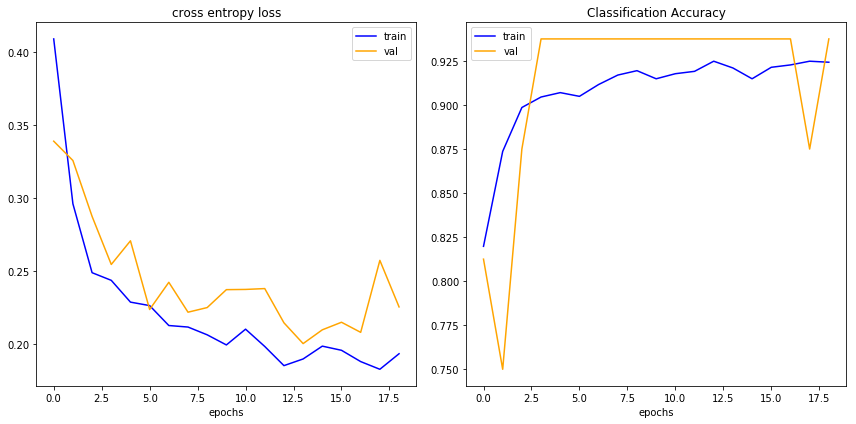

<Figure size 432x288 with 0 Axes>

In [66]:
model_plots(vgg_history)

- With vgg16 we got good results, we achieved good validation accuracy in the inital epochs itself.
- Although our model training accuracy has improved over increasing epochs but sadly validation accuracy didn't increased after 0.9375 which was obtained in the 4th epoch itself.
- It seems we further training the initial layers of vgg we can improve our model further.
- Lets evaluate our vgg model on test data.

In [67]:
test_loss, acc = vgg_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using further improved convolution neural networks is {acc * 100.0}%')
print(f'test loss on test data using further improved convolution neural networks is {test_loss}')

accuracy on test data using further improved convolution neural networks is 89.26282051282051%
test loss on test data using further improved convolution neural networks is 0.30695200577760356


- We can see 89.26% accuracy on test data using vgg model, which is arround 1% improvement our previous model.
- Since our previous model almost gave same accuracy on test data with very few layers compare to vgg, lets ditch vgg now and improve our previous model architecture and see whether its giving good results.

In [95]:
def further_improved_three_conv_model():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    #model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(256,activation='relu', kernel_initializer='he_uniform'))
    #model.add(Dense(128,activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = adam(lr=0.001)#momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [96]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            rotation_range=10)
test_datagen = ImageDataGenerator(rescale = 1./255)
# we will use .flow_from_directory() to generate batches of images data instead of loading them manually
batch_size = 16
train_generator = train_datagen.flow_from_directory(dir_path+'/train', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
valid_generator = test_datagen.flow_from_directory(dir_path+'/val', batch_size=batch_size,\
                                              class_mode='binary', target_size=(64, 64))
test_generator = test_datagen.flow_from_directory(dir_path+'/test', batch_size=batch_size,\
                                             class_mode='binary', target_size=(64, 64))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [97]:
further_imp_conv_model = further_improved_three_conv_model()
early_stopping_monitor = EarlyStopping(patience=5) 
further_impr_mul_conv_history = further_imp_conv_model.fit_generator(train_generator, steps_per_epoch=train_len//batch_size,\
                    epochs=100, validation_data=valid_generator,\
                   validation_steps=val_len//batch_size,\
                   callbacks = [early_stopping_monitor],\
                   class_weight=class_weight_dict)

Epoch 1/100
326/326 [==============================] - 87s 266ms/step - loss: 0.4689 - acc: 0.7341 - val_loss: 0.4424 - val_acc: 0.8125
Epoch 2/100
326/326 [==============================] - 85s 260ms/step - loss: 0.2549 - acc: 0.8854 - val_loss: 0.7582 - val_acc: 0.6875
Epoch 3/100
326/326 [==============================] - 86s 262ms/step - loss: 0.2105 - acc: 0.9114 - val_loss: 0.4658 - val_acc: 0.6875
Epoch 4/100
326/326 [==============================] - 85s 260ms/step - loss: 0.2546 - acc: 0.8946 - val_loss: 0.3535 - val_acc: 0.8125
Epoch 5/100
326/326 [==============================] - 85s 260ms/step - loss: 0.1891 - acc: 0.9204 - val_loss: 0.5052 - val_acc: 0.6875
Epoch 6/100
326/326 [==============================] - 84s 259ms/step - loss: 0.1812 - acc: 0.9283 - val_loss: 0.3831 - val_acc: 0.8125
Epoch 7/100
326/326 [==============================] - 85s 260ms/step - loss: 0.1732 - acc: 0.9273 - val_loss: 0.3374 - val_acc: 0.8750
Epoch 8/100
326/326 [===========================

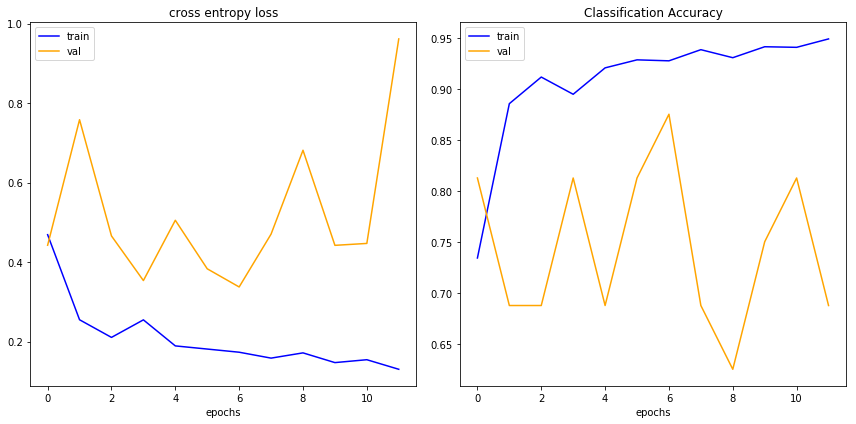

<Figure size 432x288 with 0 Axes>

In [98]:
model_plots(further_impr_mul_conv_history)

In [99]:
test_loss, acc = further_imp_conv_model.evaluate_generator(test_generator, steps=len(test_generator))
print(f'accuracy on test data using further improved convolution neural networks is {acc * 100.0}%')
print(f'test loss on test data using further improved convolution neural networks is {test_loss}')

accuracy on test data using further improved convolution neural networks is 90.06410256410257%
test loss on test data using further improved convolution neural networks is 0.47520646414695644


In [ ]:
# lets save the weights
further_imp_conv_model.save_weights('best_cnn_weights.h5')

In [ ]:
further_imp_conv_model.save("further_improved_cnn_model.h5")

In [100]:
test_generator.reset()
test_predict_proba = []
test_actual = []
for itr in range(len(test_generator)):
    b_x, b_y = test_generator.next()
    pre_list = list(further_imp_conv_model.predict_on_batch(b_x)[:,0])
    test_predict_proba.extend(pre_list)
    test_actual.extend(list(b_y))

In [101]:
test_actual_values = test_generator.classes

In [89]:
import scikitplot as skplt

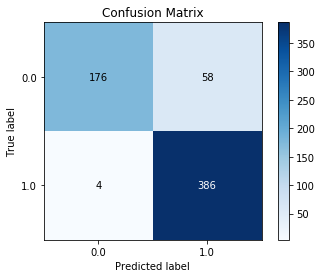

In [102]:
skplt.metrics.plot_confusion_matrix(np.array(test_actual), np.round(test_predict_proba));

In [91]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [103]:
accuracy_score(np.array(test_actual), np.round(test_predict_proba))

0.9006410256410257

In [104]:
print(classification_report(np.array(test_actual), np.round(test_predict_proba), target_names=['Normal', 'PNEUMONIA']))

              precision    recall  f1-score   support

      Normal       0.98      0.75      0.85       234
   PNEUMONIA       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



- As we can see We got a very good recall rate of 0.97 on PNEUMONIA with a precision of 0.93.
- Normally in the medical test cases recall rate is very important, we should not label a pneumonia patient as normal which puts the person in danger.
- So by using our deep learning model we got a good recall rate as well as with good precision.
- our weighted average f1-score is 0.94 which is very good.

In [94]:
#from IPython.display import FileLink
#FileLink('further_improved_cnn_model.h5')
#FileLink('best_cnn_weights.h5')